# Semi-automating bias assessment in clinical trials---a prospective, randomized evaluation
Authors list:<br>
Frank Soboczenski (1),<br>
Thomas Trikalinos(2),<br>
Joel Kuiper (3),<br>
Randolph G Bias (4),<br>
Byron C Wallace (5),<br>
Iain J Marshall (1)<br>

(1) School of Population Health and Life Sciences, King's College London, London, UK<br>
(2) Center for Evidence-based Medicine, Brown University, Providence, USA<br>
(3) Vortext Systems, Groningen, Netherlands<br>
(4) School of Information, University of Texas at Austin, Austin, USA<br>
(5) College of Computer and Information Science, Northeastern University, Boston, USA
<br>

# 1. Main Analysis 
 This Notebook is unsing an <b>R Kernel!</b><br>
 First setting up the R environment:
 

In [6]:
#set specific working directory uncomment to refer to the data files
#setwd("~/Desktop/R_STUFF")

# load performance improvement libraries & enable just in time compiler
library(compiler)
enableJIT(1)

#some environmental variables (decimals)
options=7

[1] 3

In [9]:
#check if required packages are there - if not the script will install them!
requiredPackages = c('rcompanion','gdata','compiler','car','lsr','sft','nlme', 'lme4', 'bibtex', 'psych', 'likert', 'ggplot2', 'tidyverse')
for(p in requiredPackages){
  if(!require(p,character.only = TRUE)) install.packages(p);
  library(p,character.only = TRUE);
}
#load all the libraries    
lapply(requiredPackages, require, character.only = TRUE);
#NOTE: run this cell twice for decluttering

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

In [10]:
# Importing the data 
data <- read.xls("data/TimeAnalysis2_1.xlsx", verbose=FALSE, na.strings=c("NA"))

In [11]:
# quick check on the data
head(data)

ParticipantNo,ID,PDF,Order,Time,Condition,CExperience,Tasks,NReviews,AMeanNReviews,⋯,AC2,AL2,AC3,AL3,AC4,AL4,Comments,TotalAdded,TotalDeleted,TotalSubmitted
1,-JjAzwjQakZk-3kIbeMfw,U2PXr4iMBf8Kt-leQI8Ii,1,435,1,1,9,10+,12.5,⋯,Yes,Yes,Yes,Yes,Yes,Yes,"C1:2added, C2:2added,C3:3added,C4:1added",8,0,20
1,-JjAzwjQakZk-3kIbeMfw,4gIe5sni3WJJCzNglSdo8,2,582,0,1,9,10+,12.5,⋯,Yes,No,Yes,No,Yes,No,"C1:1added, C2:1added, C3:1added, C4:2added",5,0,5
1,-JjAzwjQakZk-3kIbeMfw,iHbGgWtrKNfksdoj9Hxv9,3,297,1,1,9,10+,12.5,⋯,No,Yes,Yes,Yes,Yes,Yes,"C1:1added, C2:1added, C4:1added",3,0,15
1,-JjAzwjQakZk-3kIbeMfw,cnDXl97I_WoVUqyIH0HbQ,4,610,0,1,9,10+,12.5,⋯,No,No,No,No,Yes,No,"C1:1added, C2:0added, C3:0added",1,0,1
2,hNQKTiKtHSY_BmxLyZb9Q,XOCbiBddVQK3BYy1Ox4lI,1,306,1,1,8,5to10,7.5,⋯,No,Yes,No,Yes,No,Yes,C1:1added,1,0,16
2,hNQKTiKtHSY_BmxLyZb9Q,oOAy7INgRLumTV3vZWtVM,2,127,1,1,8,5to10,7.5,⋯,No,Yes,No,Yes,No,Yes,,0,0,15


Short comments on the data:<br>
<b>ID</b> = individual participant<br>
<b>PDF</b> = document ID<br>
<b>Order</b> = document order of appearance<br>
<b>Time</b> = Time spent on one document in seconds<br>
<b>Condition</b> = Independent variable (1 = Machine learning recommendations (MLR) present, 0 = no MLR)<br>
<b>CExperience</b> = Experience with Cochrance Risk of Bias Tool? (1 = Yes, 0 = No)<br>
<b>Tasks</b> = Number of tasks (in a systematic review) performed (9 = max)<br>
<b>NReviews</b> = Number of systematic reviews performed<br>
<b>AMeanNReviews</b> = Artithmetic Mean number of systematic reviews performed (0=0, 1-5=3, 5-10=7.5, 10+=12.5)<br>
<b>Error</b> = reported errors (ignore for now)<br>

# 1.1 Data Shape

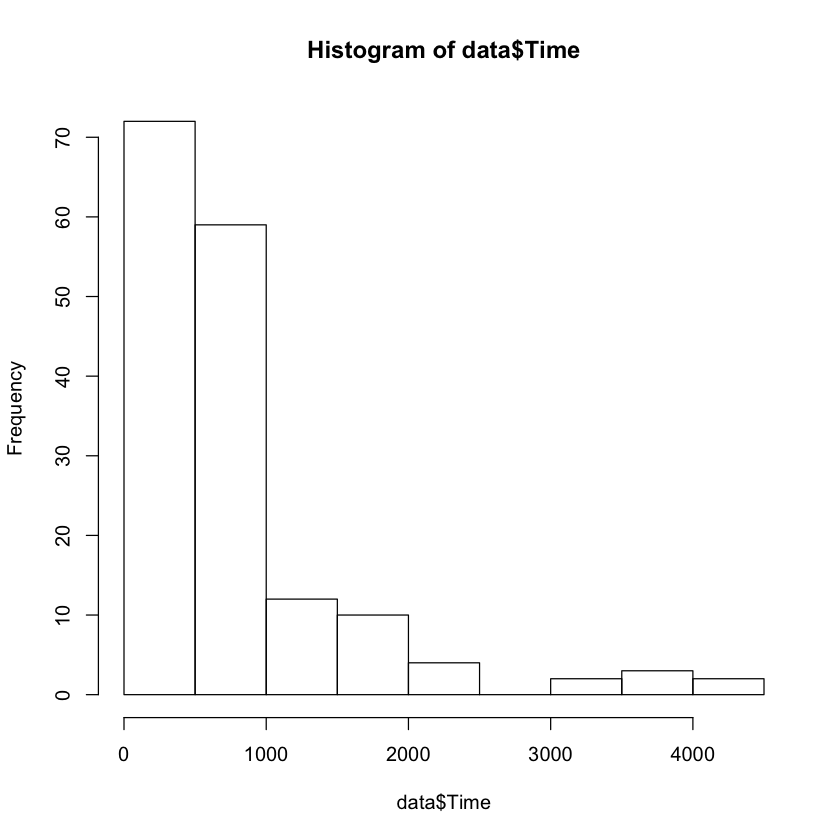

In [12]:
# first we'll look at data: the histogram
hist(data$Time)

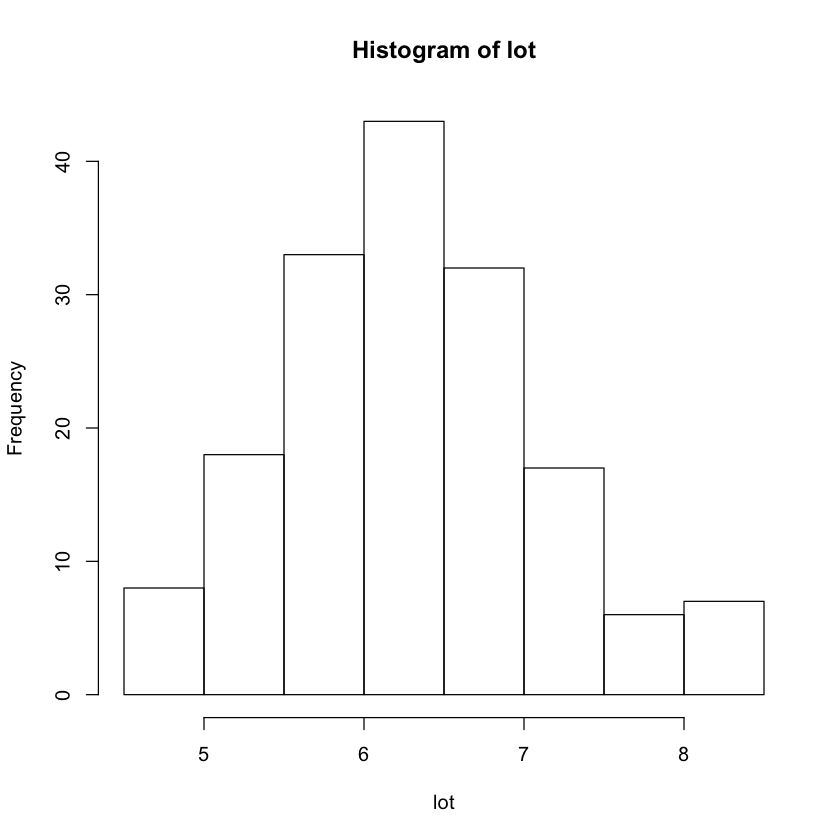

In [13]:
# However we chose to use a log representation (lot=log of time) of our data to account for 
lot <- log(data$Time)
hist(lot)

In [14]:
# we perform a shapiro-wilk test to establish if the data is parametric or not:
shapiro.test(data$Time)


	Shapiro-Wilk normality test

data:  data$Time
W = 0.69672, p-value < 2.2e-16


The Shapiro-Wilk test shows significance ($W=0.69$, $p<0.001$) which means it is highly unlikely that the data here was sampled from a normal distribution. Hence our data is non-parametric.

As this analysis is looking for differences between the two groups (machine-leanring and No-machine-learning) and as the study followed a within-jubjects design, a <b>Wilcoxon Rank-Sum test</b> is the suitable test for an initial overview of the data.


An alpha level of .05 was used for all statistical tests. A Shapiro-Wilk test showed that the timing data does not follow a normal distribution $W=0.69$, $p<0.001$. The subsequent Wilcoxon Rank-Sum test showed that there was a significant difference in time between the participants in the \textit{semi-automated} and the \textit{manual} condition $W(164)=$  13530, $p<$ 0.001 (see figure \ref{fig5}).

In [15]:
# We used th log of the timeing data for all subsequent analyses 
T_log <- log(data$Time)
# In this case the Wilcox test does not care about Log or not as it uses Rankings of bins
# Wilcox text on the Log Time of the data 
wilcox.test(T_log, data$Condition, paired = TRUE)
# We also looked at the Timing differences by documents
#wilcox.test(T_log, data$PDF, paired = TRUE)
# As well as differences in time in respect to the order 
wilcox.test(T_log, data$Order, paired = TRUE)


	Wilcoxon signed rank test with continuity correction

data:  T_log and data$Condition
V = 13530, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank test with continuity correction

data:  T_log and data$Order
V = 13530, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


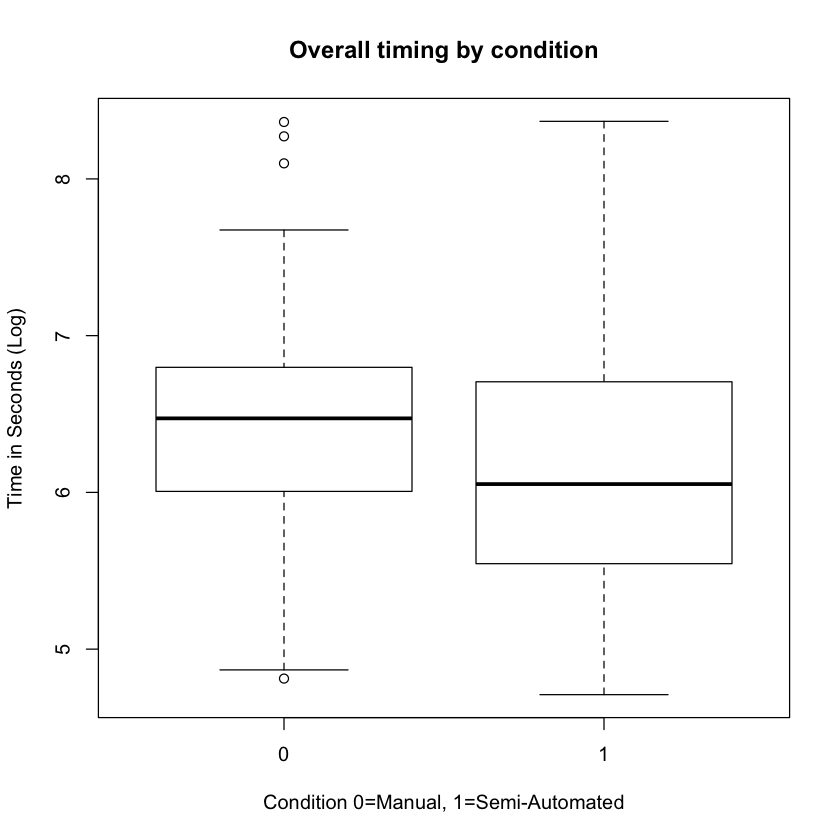

In [16]:
# We'll have a look at the boxplots now:
# For timing data (Logarithmic scale) by Condition (ML or Non-ML)
boxplot(T_log~data$Condition, xlab='Condition 0=Manual, 1=Semi-Automated', ylab="Time in Seconds (Log)", main='Overall timing by condition')
#boxplot(data$Time~data$Condition, xlab='Condition', ylab="Time in Seconds", main=axis(1, at=0:1, labels=(["N", "M"]))

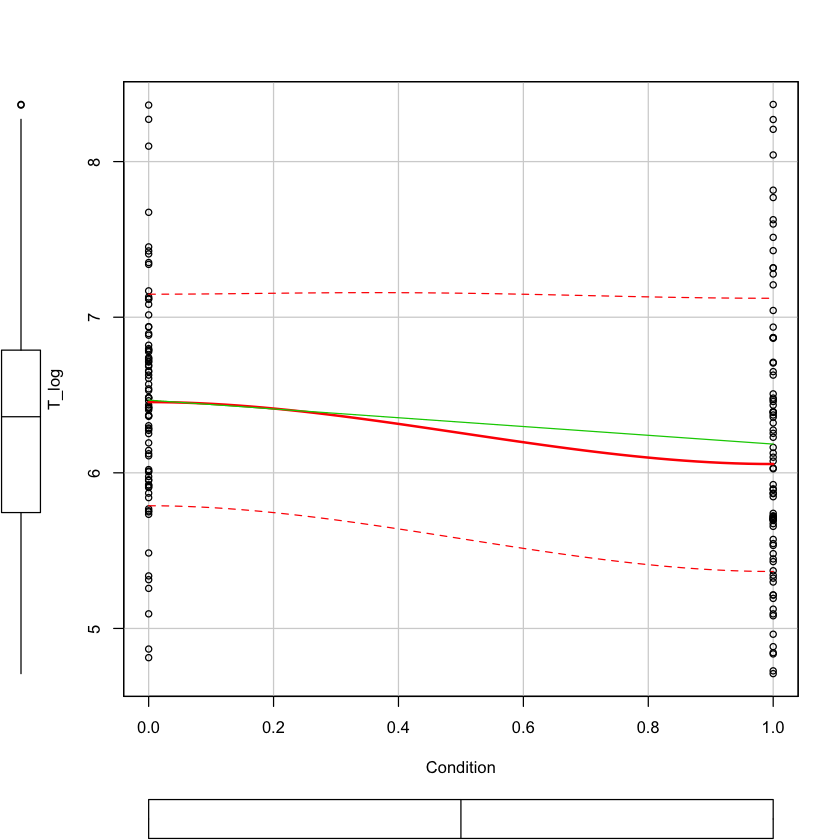

In [17]:
# also by looking at the scatterplot
scatterplot(T_log ~ Condition, data=data)

Eyeballing...there is a slight downward tendencey of time towards the MLR (1.0) condition.

In [18]:
# We also perfomed a t-test (paired because our within-participants design) to 
# check robustness
t.test(T_log, data$Condition, paired = TRUE, alternative = "two.sided")



	Paired t-test

data:  T_log and data$Condition
t = 73.028, df = 163, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 5.668718 5.983796
sample estimates:
mean of the differences 
               5.826257 


The t-test also confirms the result is highly significant! 
The t-test shows that the two groups differ significatnly from each other $t(163) = 73.02, p < 0.001$

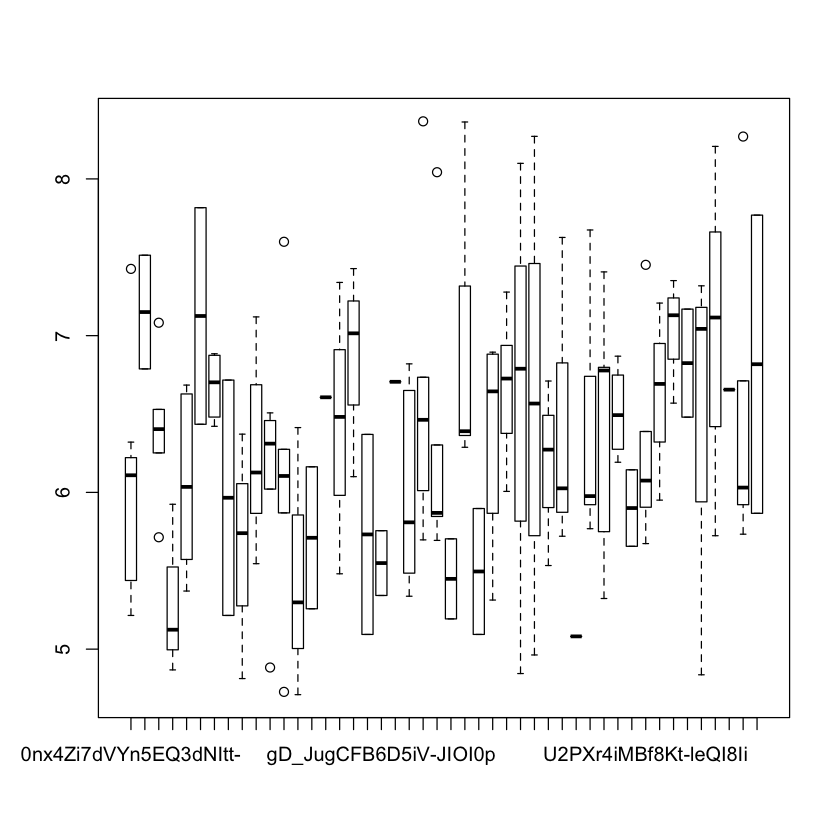

In [19]:
# before we carry on, lets have a look if there is a difference of timing in terms of the 
# documents. First the box plot:
boxplot(T_log~data$PDF)

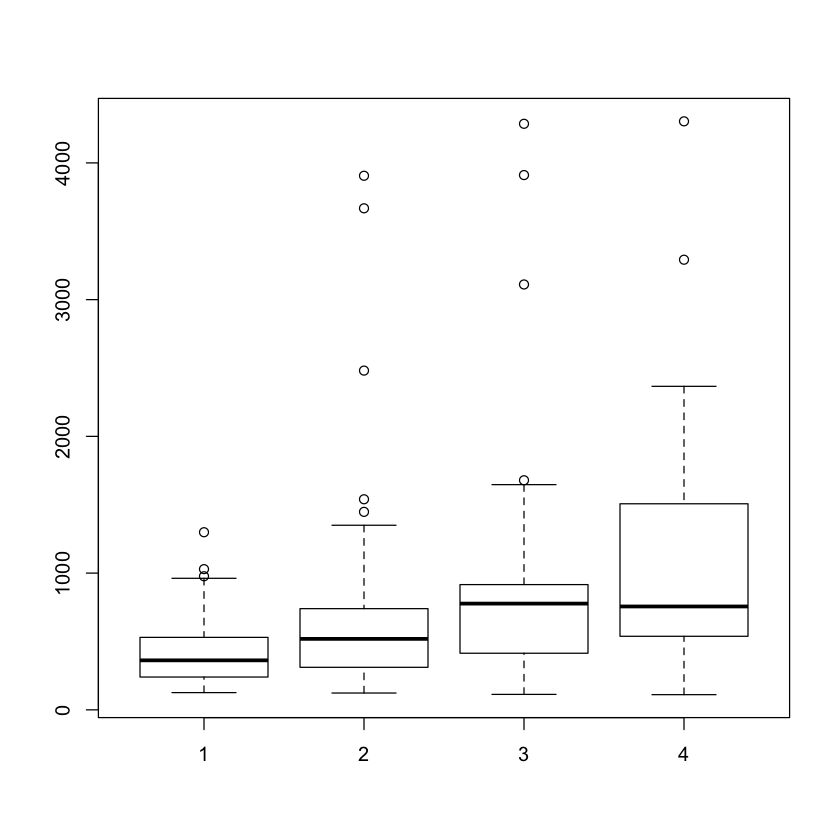

In [20]:
#Also looking at the order here First the box plot:
boxplot(data$Time~data$Order)

This nicely shows the incease in time spent on a PDF from the 1st Document participants see to the 4th.

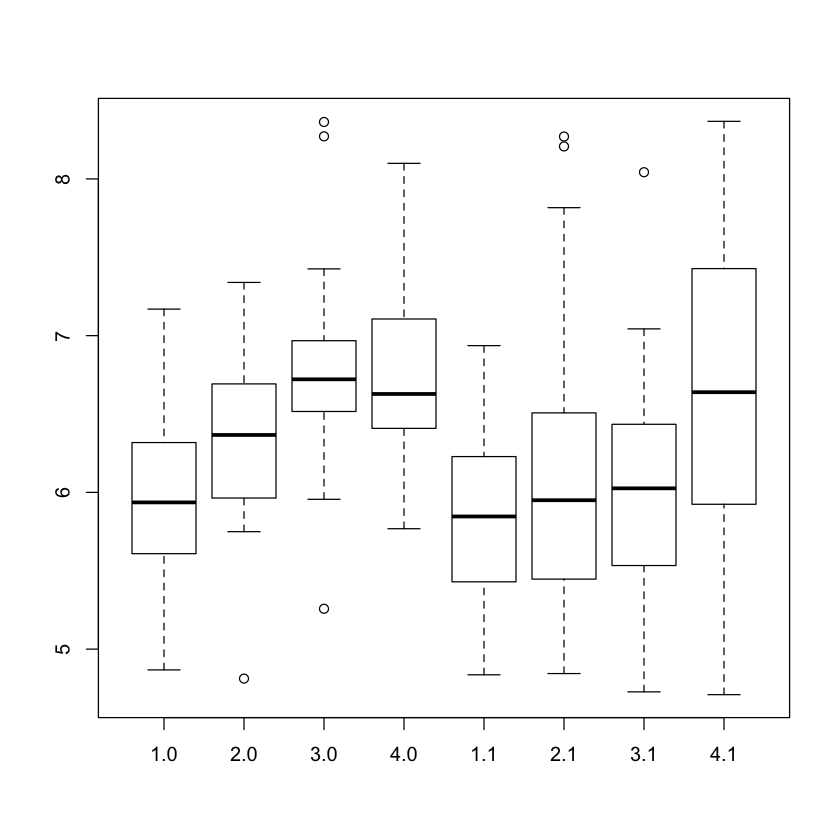

In [21]:
# Now the same plot in time (Log scale) and separated by condition 
boxplot(T_log~data$Order*data$Condition)

We can see a almost linear increase in the timing data on the non-machine learning side (1.0, 2.0, 3.0, 4.0) compared to the machine-learning side. Note, as this was a within-participants design fatigue effects are expected and can be seen here in form of the last plot 4.0 & 4.1. The timing in the machine-learning condition almost stays at a constant level except the expected last box. 

In [22]:
# Again for robustness we also performed a t-test:
t.test(T_log, data$Order, paired = TRUE, alternative = "two.sided")


	Paired t-test

data:  T_log and data$Order
t = 44.277, df = 163, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.655618 3.996895
sample estimates:
mean of the differences 
               3.826257 


The t-test shows that the Order is significantly different in terms of timing data $t(163) = 44.28, p < 0.001$

# 2. Descriptives

In [23]:
# creating two groups (ML (1) and NonML (0) )
Annotations <- subset(data, Condition=='1')
NoAnnotations <- subset(data, Condition=='0')

In [24]:
# checking the data
head(Annotations)

,ParticipantNo,ID,PDF,Order,Time,Condition,CExperience,Tasks,NReviews,AMeanNReviews,⋯,AC2,AL2,AC3,AL3,AC4,AL4,Comments,TotalAdded,TotalDeleted,TotalSubmitted
1,1,-JjAzwjQakZk-3kIbeMfw,U2PXr4iMBf8Kt-leQI8Ii,1,435,1,1,9,10+,12.5,⋯,Yes,Yes,Yes,Yes,Yes,Yes,"C1:2added, C2:2added,C3:3added,C4:1added",8,0,20
3,1,-JjAzwjQakZk-3kIbeMfw,iHbGgWtrKNfksdoj9Hxv9,3,297,1,1,9,10+,12.5,⋯,No,Yes,Yes,Yes,Yes,Yes,"C1:1added, C2:1added, C4:1added",3,0,15
5,2,hNQKTiKtHSY_BmxLyZb9Q,XOCbiBddVQK3BYy1Ox4lI,1,306,1,1,8,5to10,7.5,⋯,No,Yes,No,Yes,No,Yes,C1:1added,1,0,16
6,2,hNQKTiKtHSY_BmxLyZb9Q,oOAy7INgRLumTV3vZWtVM,2,127,1,1,8,5to10,7.5,⋯,No,Yes,No,Yes,No,Yes,,0,0,15
10,3,pyTvUi2W85Nb9handPSvZ,gD_JugCFB6D5iV-JIOI0p,2,209,1,1,9,5to10,7.5,⋯,No,Yes,No,Yes,No,Yes,,0,0,15
12,3,pyTvUi2W85Nb9handPSvZ,4gIe5sni3WJJCzNglSdo8,4,756,1,1,9,5to10,7.5,⋯,Yes,Yes,Yes,Yes,Yes,Yes,"C1:1added all left;C2:1added all left,C3:1added,C4:1added",4,0,19


In [25]:
cat("Time Overall: ", sum(data$Time), '\n')
cat("Overall Mean Time: ", mean(data$Time), '\n')
cat("Overall SD Time: ", sd(data$Time), '\n')
cat('_____________________________________________', '\n')
cat("Time in Annotations: ", sum(Annotations$Time), "Time in NoAnnotations: ", sum(NoAnnotations$Time), '\n') 
cat("Mean Annotations: ", mean(Annotations$Time), "Mean NoAnnotations: ", mean(NoAnnotations$Time), '\n') 
cat("SD Annotations: ", sd(Annotations$Time), "SD NoAnnotations: ", sd(NoAnnotations$Time), '\n') 
cat('_____________________________________________', '\n')


Time Overall:  129454 
Overall Mean Time:  789.3537 
Overall SD Time:  794.4597 
_____________________________________________ 
Time in Annotations:  61913 Time in NoAnnotations:  67541 
Mean Annotations:  755.0366 Mean NoAnnotations:  823.6707 
SD Annotations:  868.4611 SD NoAnnotations:  716.6 
_____________________________________________ 


Forty-one participants were recruited. All except four had experience of at least one systematic review and all but eight were familiar with the Cochrane Risk of Bias tool (ref). Twenty listed more than one task on how they contributed to previsous systematic reviews.

A mean of 755 seconds (SD 868) were taken for \textit{semi-automated} bias assesmsents and 824 seconds (SD 717) for \textit{manual} assessments (see table \ref{table2}; $P<0.001$) <br>

Participants spent in total 129454 seconds ($Mean$=789.35, $SD$=794.46) to complete the study together in both conditions (\textit{semi-automated} and \textit{manual}).<br>

# 3. Tukey Ladder of Powers
The \textit{Tukey Ladder of Powers} \cite{} was used to transform the response variable (time) to come closer to a normal distribution. The resulting $\lambda =$ -0.15 is close to 0 which confirms that the optimal transformation according to the \textit{Tukey Ladder of Powers} is indeed a logarithmic operation. For the following mixed model analysis the timing data was therefore transformed to a logarithmic scale.

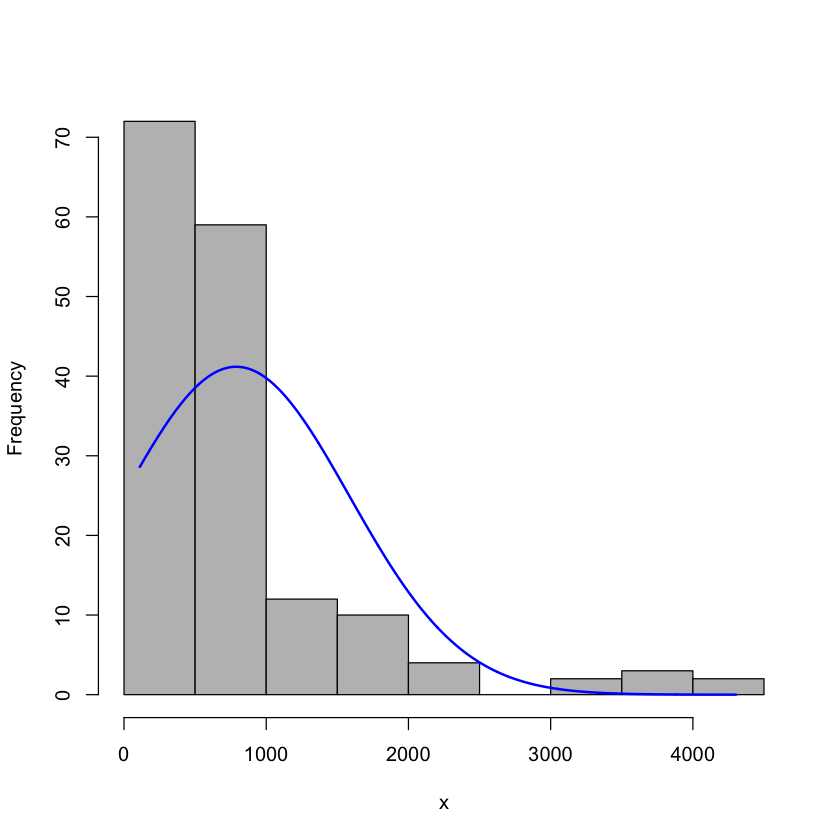

In [26]:
# Quick look at the data 
plotNormalHistogram(data$Time)

In [27]:
# cheching the data transformation:
T_tuk = transformTukey(data$Time, plotit=FALSE)


    lambda      W Shapiro.p.value
395  -0.15 0.9907          0.3626

if (lambda >  0){TRANS = x ^ lambda} 
if (lambda == 0){TRANS = log(x)} 
if (lambda <  0){TRANS = -1 * x ^ lambda} 



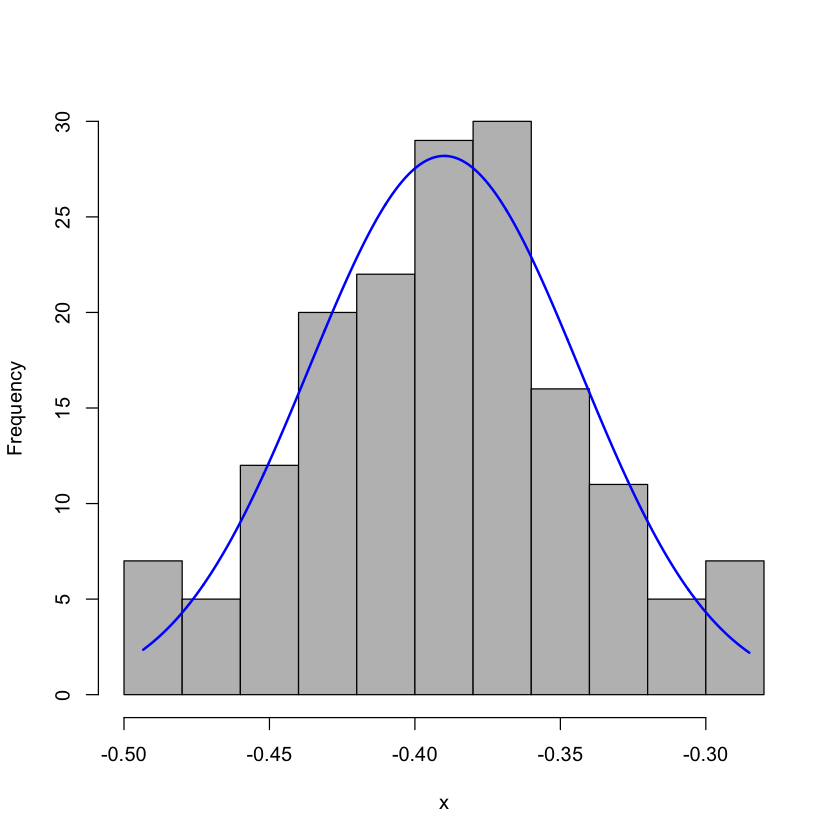

In [28]:
# plotting the transformed data
plotNormalHistogram(T_tuk)

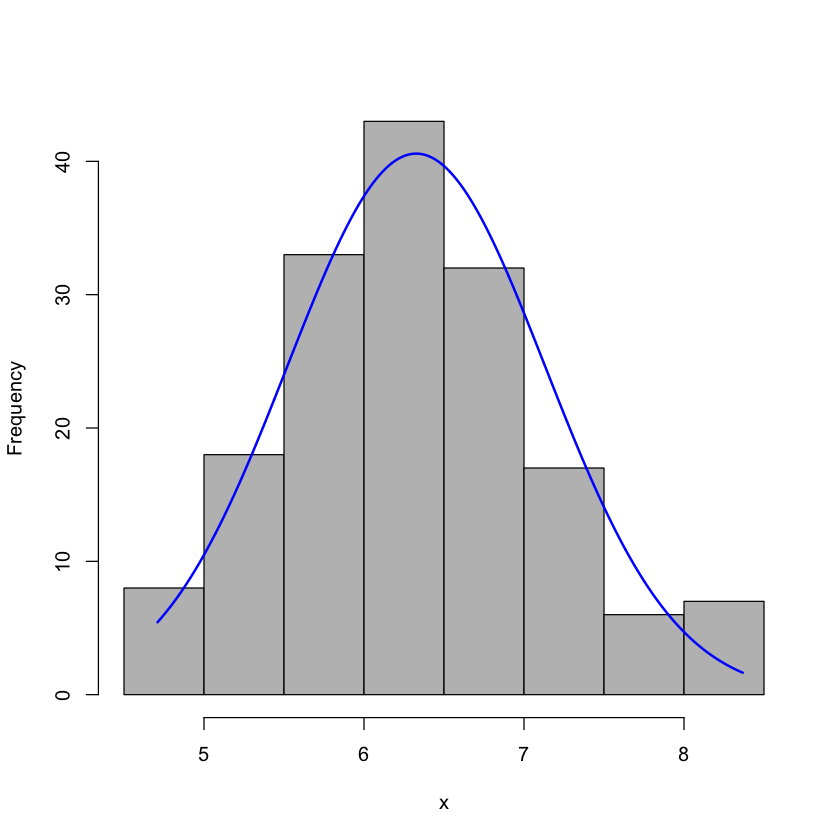

In [29]:
# Now using the log of the data and plotting it:
plotNormalHistogram(T_log)

The <b>Tukey Ladder of Powers</b> was used to transform the response variable (time) to come closer to a normal distribution. The resulting $\lambda =$ -0.15 is close to 0 which confirms that the optimal transformation according to the \textit{Tukey Ladder of Powers} is indeed a logarithmic operation. For the following mixed model analysis the timing data was therefore transformed to a logarithmic scale.

#  X.1 COMMENTS: 
If we do not use the completely transformed data then we do not have a very nice distribution as we have some timings that are quite large. The Lambda -0.15 is fine. One approach would be to just say we logged the data. Even if it is not optimal with the Shapiro-Wilk test - that is ok. The original model would suffer a bit more than the log would suffer. One version would be to say we just use the logged version because its more normally distributed. Then we keep the raw times as a secondary analysis to see if the results make sense. 

# 4. Linear Mixed Effects Model Analysis
A linear mixed effects model was used to examine the associations between the  log transformed time response, the \textit{semi-automatic} or \textit{manual} condition, the order in which a document was randomly presented and self reported characteristics of the reviewers.

##  4.1 Primary model analysis

In [30]:
# first add the log time to the data frame
data$logT <- log(data$Time)
# create the primary model: Log(Time) by Condition as fixed effects and ID as random effect:
ml.p = lmer(logT ~ Condition + (1 | ID), data=data)

In [31]:
summary(ml.p)

Linear mixed model fit by REML ['lmerMod']
Formula: logT ~ Condition + (1 | ID)
   Data: data

REML criterion at convergence: 374.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.29905 -0.63291  0.02993  0.55999  2.47915 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.2085   0.4566  
 Residual             0.4277   0.6540  
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)   6.4678     0.1015   63.73
Condition    -0.2832     0.1021   -2.77

Correlation of Fixed Effects:
          (Intr)
Condition -0.503

In [32]:
# looking at coefficients by ID
coef(ml.p)$ID 

,(Intercept),Condition
-JjAzwjQakZk-3kIbeMfw,6.342909,-0.2831514
-O8MP5AR-esmcnFcENyoF,6.402884,-0.2831514
-YoLEIFk1XZUJo3BgVmlp,6.723705,-0.2831514
2K-K26QZH9xPJH9RVMltM,6.419611,-0.2831514
2snvok14kLm_dRIdL67PF,6.223803,-0.2831514
3CDOco99k3UGgia7A9LQo,7.275245,-0.2831514
4dkYUV8wlkm_Q5miw0qCJ,6.865738,-0.2831514
5h9rXuHepqDSmetOKXM0J,6.557449,-0.2831514
5SAqbCbqZP_q7hVWTEJdL,5.615216,-0.2831514
8arsi19w5sMwMmpkmM0sX,6.415119,-0.2831514


In [33]:
# the mean values
coef(summary(ml.p))[,"Estimate"]

(Intercept)   Condition 
  6.4678324  -0.2831514

In [34]:
# establishing the confidence intervalls:
confint(ml.p)

Computing profile confidence intervals ...


,2.5 %,97.5 %
.sig01,0.3074827,0.62121739
.sigma,0.5777147,0.74206725
(Intercept),6.2682066,6.66745826
Condition,-0.4840935,-0.08220934


The confidence intervals are -0.48 to -0.08 -> exp(-0.48)=62% to exp(-0.08)=92% )

In [35]:
# main speed up = 100 - 0.75 = 25%
exp(-.28)

[1] 0.7557837

The primary model ($m_p$) took the log transformed time and the condition (\textit{semi-automated or manual}) as fixed effects and the individuals as random effect into account. Participants performing bias assessments in the \textit{semi-automated} condition were on average 25\% quicker than the participants in the \textit{manual} condition (95\% CI 62\% to 92\%).\newline


# 4.2 Exploratory Analysis


#### Now continuing with Exploratory Analisys (Likelihood Ratio)

In addition, model $m_1$ took also the Order as fixed effect and the document as random effect into account. whereas $m_2$ did 
only account for the document as random effect to examine the importance of the Order in the model. A close examination for $m_1$ 
showed that there was a random intercept for every PDF. The random effect variance of the documents is 0.02 (about 1/10th) as 
high as from the individuals (0.23). Hence, there is more variance across participants than there is across documents. 
The subsequent likelihood-ratio test showed that the Order was highly significant $\chi^2$(1) = 42.26, $p<$ 0.001. 
Therefore the Order was kept in the following models.\newline 

In [36]:
# What is the effect of the PDF, Order, Condition and Person?
ml.1 = lmer(logT ~ Order + Condition + (1|ID) + (1|PDF), data=data, REML=FALSE)
ml.2 = lmer(logT ~ Condition + (1|ID) + (1|PDF), data=data, REML=FALSE)

In [37]:
summary(ml.1)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Order + Condition + (1 | ID) + (1 | PDF)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   338.2    356.8   -163.1    326.2      158 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.05956 -0.44213 -0.01847  0.60865  2.15485 

Random effects:
 Groups   Name        Variance Std.Dev.
 PDF      (Intercept) 0.02466  0.1571  
 ID       (Intercept) 0.23839  0.4883  
 Residual             0.27691  0.5262  
Number of obs: 164, groups:  PDF, 46; ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.78065    0.13809   41.86
Order        0.27151    0.03781    7.18
Condition   -0.27389    0.08498   -3.22

Correlation of Fixed Effects:
          (Intr) Order 
Order     -0.691       
Condition -0.319  0.012

In [38]:
summary(ml.2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Condition + (1 | ID) + (1 | PDF)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   378.5    394.0   -184.2    368.5      159 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.29806 -0.63552  0.02841  0.55830  2.49665 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 PDF      (Intercept) 2.306e-15 4.802e-08
 ID       (Intercept) 2.016e-01 4.490e-01
 Residual             4.243e-01 6.514e-01
Number of obs: 164, groups:  PDF, 46; ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)   6.4678     0.1005   64.38
Condition    -0.2832     0.1017   -2.78

Correlation of Fixed Effects:
          (Intr)
Condition -0.506

In [39]:
# Likelihood-Ratio analysis (ANOVA) to see if the Order is important
anova(ml.1, ml.2)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
ml.2,5,378.4641,393.9634,-184.2321,368.4641,NA,NA,NA
ml.1,6,338.1962,356.7954,-163.0981,326.1962,42.26793,1,7.958708e-11


This tells us (and confirms previous overall results) to keep the order: <br>
The Likelihood-Ratio analysis (Anova) between $m_1$ and $m_2$ tells us that the order is highly significant ($p<0.001$).<br>
That is an indication to keep the order in the model.<br>
Let's again take a look at model $m_1$

In [40]:
summary(ml.1)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Order + Condition + (1 | ID) + (1 | PDF)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   338.2    356.8   -163.1    326.2      158 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.05956 -0.44213 -0.01847  0.60865  2.15485 

Random effects:
 Groups   Name        Variance Std.Dev.
 PDF      (Intercept) 0.02466  0.1571  
 ID       (Intercept) 0.23839  0.4883  
 Residual             0.27691  0.5262  
Number of obs: 164, groups:  PDF, 46; ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.78065    0.13809   41.86
Order        0.27151    0.03781    7.18
Condition   -0.27389    0.08498   -3.22

Correlation of Fixed Effects:
          (Intr) Order 
Order     -0.691       
Condition -0.319  0.012

We have a random intercept for every PDF. We can see that the random effect variance of PDF is about 1/10th as high as the variance from the ID. So there is more variance across people than there is across PDF (document) related.<br>
Let's examine a model $m_3$ (removed the PDF random effect):

In [41]:
ml.3 = lmer(logT ~ Order + Condition + (1|ID), data=data, REML=FALSE)

In [42]:
# again likelihood-ratio analysis (ANOVA) now looking at the difference between m_1 and m_3 :
anova(ml.1, ml.3)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
ml.3,5,336.9199,352.4193,-163.4600,326.9199,NA,NA,NA
ml.1,6,338.1962,356.7954,-163.0981,326.1962,0.723746,1,0.3949179


Model $m_3$ did not have the document as random effect in order to see if it had an influence. The following likelihood-ratio comparisons with $m_1$ showed that there was no significance which suggests that there is little variability from documents and by ignoring this does not detract from the explanatory potential of the model $\chi^2$(1) = 0.72, $p=$ 0.39.

There is <b>no significance!</b> This means we do not care so much for the PDF random effect.<br> 
In fact we could loose the PDF random effect without destroying the known universe.<br>
So let's see the random effects coefficients:

In [43]:
coef(ml.3)


$ID
                      (Intercept)     Order  Condition
-JjAzwjQakZk-3kIbeMfw    5.646676 0.2701334 -0.2765628
-O8MP5AR-esmcnFcENyoF    5.715102 0.2701334 -0.2765628
-YoLEIFk1XZUJo3BgVmlp    6.081139 0.2701334 -0.2765628
2K-K26QZH9xPJH9RVMltM    5.734187 0.2701334 -0.2765628
2snvok14kLm_dRIdL67PF    5.510783 0.2701334 -0.2765628
3CDOco99k3UGgia7A9LQo    6.710410 0.2701334 -0.2765628
4dkYUV8wlkm_Q5miw0qCJ    6.243188 0.2701334 -0.2765628
5h9rXuHepqDSmetOKXM0J    5.891452 0.2701334 -0.2765628
5SAqbCbqZP_q7hVWTEJdL    4.816425 0.2701334 -0.2765628
8arsi19w5sMwMmpkmM0sX    5.729063 0.2701334 -0.2765628
C07qGfUuD1L-1IoLjtOXY    5.908558 0.2701334 -0.2765628
C4xWyqDJrsHcIoHU5GtUG    6.429523 0.2701334 -0.2765628
Ci3GWDLAOc5ANxkPpNOBc    5.722301 0.2701334 -0.2765628
cs1qlmKFvdkFjUcXEkJgT    5.747713 0.2701334 -0.2765628
FfUZhXrHdKSHZ3ON2_Dty    6.016796 0.2701334 -0.2765628
fQoBVJ60uF5ehuYNAg4v2    5.732324 0.2701334 -0.2765628
FXvg7iTf7P1bl-Z9dHKPO    5.747617 0.2701334 -0.2765628
GR96Rb

In [44]:
summary(ml.3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Order + Condition + (1 | ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   336.9    352.4   -163.5    326.9      159 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.19339 -0.52439 -0.01335  0.53696  2.27474 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.2320   0.4817  
 Residual             0.3027   0.5501  
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.78920    0.13663   42.37
Order        0.27013    0.03843    7.03
Condition   -0.27656    0.08592   -3.22

Correlation of Fixed Effects:
          (Intr) Order 
Order     -0.707       
Condition -0.322  0.011

The variance of coefficients 0.23<br>
Do different people have a different coefficient when it comes to the Machine learning (random slope)?<br>
One option to examine this is to include the condition also as random effect. So there is an overall mean for the machine learning, but how variable does it seem to be?

In [45]:
# including the condition also as random effect in model m_3
ml.3 = lmer(logT ~ Order + Condition + (Condition | ID), data=data, REML=FALSE)

In [46]:
summary(ml.3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Order + Condition + (Condition | ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   328.0    349.7   -157.0    314.0      157 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3985 -0.4850  0.0052  0.5775  2.2962 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 ID       (Intercept) 0.1487   0.3856       
          Condition   0.2000   0.4473   0.29
 Residual             0.2361   0.4859       
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.76592    0.12264   47.01
Order        0.27940    0.03678    7.60
Condition   -0.27634    0.10314   -2.68

Correlation of Fixed Effects:
          (Intr) Order 
Order     -0.753       
Condition -0.138  0.009

There seems to be variability in the slope. So different people seem to react differently to the machine learning condition. It seems that the residual variance has dropped between the first $m_3$ and updated $m_3$ models: It was .40 in the first $m_3$ now in the updated $m_3$ it is .24. Perhaps this model explains a bit more. Let's take a look at the coefficients:

In [47]:
# coefficients by ID
coef(ml.3)$ID 

,(Intercept),Order,Condition
-JjAzwjQakZk-3kIbeMfw,5.645644,0.2794002,-0.31868291
-O8MP5AR-esmcnFcENyoF,5.689063,0.2794002,-0.24591965
-YoLEIFk1XZUJo3BgVmlp,6.018559,0.2794002,-0.21255577
2K-K26QZH9xPJH9RVMltM,5.758266,0.2794002,-0.43458312
2snvok14kLm_dRIdL67PF,5.533983,0.2794002,-0.37010571
3CDOco99k3UGgia7A9LQo,6.471687,0.2794002,0.25956400
4dkYUV8wlkm_Q5miw0qCJ,6.085542,0.2794002,0.09094654
5h9rXuHepqDSmetOKXM0J,5.825058,0.2794002,-0.14658113
5SAqbCbqZP_q7hVWTEJdL,5.065488,0.2794002,-1.00634718
8arsi19w5sMwMmpkmM0sX,5.665417,0.2794002,-0.11211088


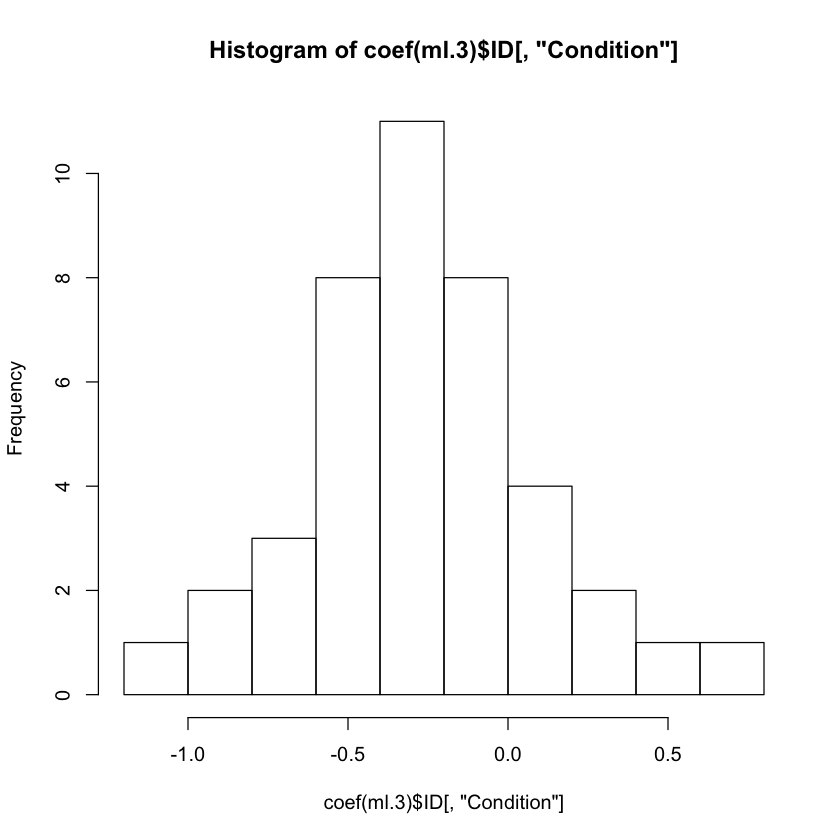

In [48]:
# histogram about those conditions:
hist(coef(ml.3)$ID[,"Condition"])

So there seems to be some people who do it faster and some slower so there seems to be some heterogeneity. Model $m_4$ adds the random effect per person:

In [49]:
ml.4 = lmer(logT ~ Order + Condition + (Condition|ID), data=data, REML=FALSE)

In [50]:
# again likelihood-ratio (ANOVA) to see the differences between models:
anova(ml.4, ml.3)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
ml.4,7,328.0184,349.7175,-157.0092,314.0184,NA,NA,NA
ml.3,7,328.0184,349.7175,-157.0092,314.0184,0,0,1


Not significant: $\chi^2$(0) = 0.0, $p=$ 1.

In [51]:
# Do we need the Order if we have the condition as a random effect?
ml.5 = lmer(logT ~ Condition + (Condition|ID), data=data, REML=FALSE)

In [52]:
# Differences in models:
anova(ml.4, ml.5)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
ml.5,6,372.7248,391.3240,-180.3624,360.7248,NA,NA,NA
ml.4,7,328.0184,349.7175,-157.0092,314.0184,46.70645,1,8.245712e-12


Yes, significant! The order is still important: $\chi^2$(1) = 46.70, $p<$ 0.001.

In [53]:
# examining model m_4
summary(ml.4)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Order + Condition + (Condition | ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   328.0    349.7   -157.0    314.0      157 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3985 -0.4850  0.0052  0.5775  2.2962 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 ID       (Intercept) 0.1487   0.3856       
          Condition   0.2000   0.4473   0.29
 Residual             0.2361   0.4859       
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.76592    0.12264   47.01
Order        0.27940    0.03678    7.60
Condition   -0.27634    0.10314   -2.68

Correlation of Fixed Effects:
          (Intr) Order 
Order     -0.753       
Condition -0.138  0.009

In [54]:
# examining model m_5
summary(ml.5)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Condition + (Condition | ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   372.7    391.3   -180.4    360.7      158 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.34127 -0.62213  0.05227  0.57998  2.21132 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 ID       (Intercept) 0.1069   0.3270       
          Condition   0.1603   0.4003   0.52
 Residual             0.3708   0.6090       
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  6.46783    0.08444   76.60
Condition   -0.28315    0.11381   -2.49

Correlation of Fixed Effects:
          (Intr)
Condition -0.298

Interestingly, both of the models have the same variance with different sign (indication for colinearty?). However, the order is not exactly random. Each prticipant has two documents of each. It is a random ordering. Each participant will have for sure two ML and two Non-ML conditions / documents.<br>

After we remove the order in model $m_5$ the condition variance is roughly the same.
Before was -27 now is -28.




# 5. Reviewer Jugements & Annotations Analysis

## 5.1 Descriptives

In [55]:
# Some descriptitves
# TOTAL first (Annotations & NonAnnotations together)
cat('____________TOTAL DATA:______________________', '\n')
cat("Total Annotations added:", sum(data$TotalAdded), '\n')
cat("Mean Total Annotations added:", mean(data$TotalAdded), '\n')
cat("SD Total Annotations added:", sd(data$TotalAdded), '\n')
cat('_____________________________________________', '\n')

cat("Total Annotations deleted:", sum(data$TotalDeleted), '\n')
cat("Mean Total Annotations deleted:", mean(data$TotalDeleted), '\n')
cat("SD Total Annotations deleted:", sd(data$TotalDeleted), '\n')
cat('\n')


cat('____________MACHINE LEARNING:________________', '\n')

# Now only for Machine-Learning Condition
cat("Total Annotations added:", sum(Annotations$TotalAdded), '\n')
cat("Mean Total Annotations added:", mean(Annotations$TotalAdded), '\n')
cat("SD Total Annotations added:", sd(Annotations$TotalAdded), '\n')
cat('_____________________________________________', '\n')

cat("Total Annotations deleted:", sum(Annotations$TotalDeleted), '\n')
cat("Mean Total Annotations deleted:", mean(Annotations$TotalDeleted), '\n')
cat("SD Total Annotations deleted:", sd(Annotations$TotalDeleted), '\n')
cat('\n')

cat('____________NON-MACHINE LEARNING: ___________', '\n')

# And for the Non-Machine-Learning Condition
cat("Total Annotations added:", sum(NoAnnotations$TotalAdded), '\n')
cat("Mean Total Annotations added:", mean(NoAnnotations$TotalAdded), '\n')
cat("SD Total Annotations added:", sd(NoAnnotations$TotalAdded), '\n')
cat('_____________________________________________', '\n')

cat("Total Annotations deleted:", sum(NoAnnotations$TotalDeleted), '\n')
cat("Mean Total Annotations deleted:", mean(NoAnnotations$TotalDeleted), '\n')
cat("SD Total Annotations deleted:", sd(NoAnnotations$TotalDeleted), '\n')


____________TOTAL DATA:______________________ 
Total Annotations added: 486 
Mean Total Annotations added: 2.963415 
SD Total Annotations added: 3.033333 
_____________________________________________ 
Total Annotations deleted: 127 
Mean Total Annotations deleted: 0.7743902 
SD Total Annotations deleted: 1.957607 

____________MACHINE LEARNING:________________ 
Total Annotations added: 103 
Mean Total Annotations added: 1.256098 
SD Total Annotations added: 1.755492 
_____________________________________________ 
Total Annotations deleted: 127 
Mean Total Annotations deleted: 1.54878 
SD Total Annotations deleted: 2.549037 

____________NON-MACHINE LEARNING: ___________ 
Total Annotations added: 383 
Mean Total Annotations added: 4.670732 
SD Total Annotations added: 3.087429 
_____________________________________________ 
Total Annotations deleted: 0 
Mean Total Annotations deleted: 0 
SD Total Annotations deleted: 0 


## 5.2 Descriptives Self-Reported characteristics

In [60]:
# using a subset of the above main data here:
data_s <- read.xls("data/subset_selfreported.xlsx", verbose=FALSE, na.strings=c("NA"))
# and filtering out douplicates
data_s2 <- unique(data_s)

In [61]:
# quick check on the data
head(data_s2)

,ID,CExperience,Tasks,NReviews
1,-JjAzwjQakZk-3kIbeMfw,1,9,10+
5,hNQKTiKtHSY_BmxLyZb9Q,1,8,5to10
9,pyTvUi2W85Nb9handPSvZ,1,9,5to10
13,2K-K26QZH9xPJH9RVMltM,1,9,10+
17,8arsi19w5sMwMmpkmM0sX,1,9,10+
21,GR96RbbiPLL4gS3-ilxky,1,9,1to5


In [63]:
# Calculating Descriptive Self-reported characteristics data:
NumberOfReviews0 <- sum(data_s2$NReviews=='0')
NumberOfReviews1_5 <- sum(data_s2$NReviews=='1to5')
NumberOfReviews5_0 <- sum(data_s2$NReviews=='5to10')
NumberOfReviews10plus <- sum(data_s2$NReviews=='10+')
NumberOfReviews0 
NumberOfReviews1_5 
NumberOfReviews5_0
NumberOfReviews10plus

NumberOfReviews0_percentage <- NumberOfReviews0/41
NumberOfReviews1_5_percentage <- NumberOfReviews1_5/41
NumberOfReviews5_0_percentage <- NumberOfReviews5_0/41
NumberOfReviews10plus_percentage <- NumberOfReviews10plus/41
NumberOfReviews0_percentage 
NumberOfReviews1_5_percentage
NumberOfReviews5_0_percentage
NumberOfReviews10plus_percentage

TotalSumOfPeopleWithCochraneExperience <- sum(data_s2$CExperience=='1')
TotalSumOfPeopleWithoutCochraneExperience <- sum(data_s2$CExperience=='0')
TotalSumOfPeopleWithCochraneExperience
TotalSumOfPeopleWithoutCochraneExperience

Percentage_TotalSumOfPeopleWithCochraneExperience <- TotalSumOfPeopleWithCochraneExperience/41
Percentage_TotalSumOfPeopleWithoutCochraneExperience <- TotalSumOfPeopleWithoutCochraneExperience/41
Percentage_TotalSumOfPeopleWithCochraneExperience
Percentage_TotalSumOfPeopleWithoutCochraneExperience

MedianOfTasksPerfomed <- median(data_s2$Tasks)
IRQofTasksPerformed <- quantile(data_s2$Tasks)
MedianOfTasksPerfomed
IRQofTasksPerformed


[1] 5

[1] 9

[1] 12

[1] 15

[1] 0.1219512

[1] 0.2195122

[1] 0.2926829

[1] 0.3658537

[1] 32

[1] 9

[1] 0.7804878

[1] 0.2195122

[1] 8

0%  25%  50%  75% 100% 
   1    6    8    9    9

## 5.3 Jugdement Agrement Data

In [66]:
# Importing the data 
data_agreement <- read.xls("data/agreement.xlsx", verbose=FALSE, na.strings=c("NA"))

In [68]:
# calculating the changed data and percentiles:
RSG <- sum(data_agreement$Changed)
AC <- sum(data_agreement$Changed.1)
BPP <- sum(data_agreement$Changed.2)
BOA <- sum(data_agreement$Changed.3)
Overall <- RSG+AC+BPP+BOA
RSG/164
AC/164
BPP/164
BOA/164
RSG
AC
BPP
BOA
Overall

[1] 0.1158537

[1] 0.09146341

[1] 0.1402439

[1] 0.2378049

[1] 19

[1] 15

[1] 23

[1] 39

[1] 96

## 5.4 Annotations Data

In [70]:
# Overall mean annotations
data <- read.xls("data/TimeAnalysis2_1.xlsx", verbose=FALSE, na.strings=c("NA"))
data2 <- subset(data, Condition=='1')
data3 <- subset(data, Condition=='0')

mean(data2$TotalSubmitted)
mean(data3$TotalSubmitted)


[1] 14.63415

[1] 4.670732

In [71]:
##############
# annotations

data <- read.xls("data/annotationschanged.xlsx", verbose=FALSE, na.strings=c("NA"))
data2 <- subset(data, Condition=='1')
data3 <- subset(data, Condition=='0')



RSG1 <- sum(data2$Changed1=='0')
RSG2 <- sum(data2$Changed1=='1')
RSG3 <- sum(data2$Changed1=='2')
RSG1/82
RSG2/82
RSG3/82

AC1 <- sum(data2$Changed2=='0')
AC2 <- sum(data2$Changed2=='1')
AC3 <- sum(data2$Changed2=='2')
AC1/82
AC2/82
AC3/82

BPP1 <- sum(data2$Changed3=='0')
BPP2 <- sum(data2$Changed3=='1')
BPP3 <- sum(data2$Changed3=='2')
BPP1/82
BPP2/82
BPP3/82

BOA1 <- sum(data2$Changed4=='0')
BOA2 <- sum(data2$Changed4=='1')
BOA3 <- sum(data2$Changed4=='2')
BOA1/82
BOA2/82
BOA3/82

TotalUnchanged <- RSG1+AC1+BPP1+BOA1
TotalUnchanged/328

TotalChangedML <- RSG2+AC2+BPP2+BOA2
TotalChangedML/328

TotalChangedNoML <- RSG3+AC3+BPP3+BOA3
TotalChangedNoML/328

[1] 0.5609756

[1] 0.4146341

[1] 0.02439024

[1] 0.6219512

[1] 0.3414634

[1] 0.03658537

[1] 0.6341463

[1] 0.3292683

[1] 0.03658537

[1] 0.6463415

[1] 0.2926829

[1] 0.06097561

[1] 0.6158537

[1] 0.3445122

[1] 0.03963415

# 6. QUESTIONNAIRE ANALYSIS

In [77]:
# loading the data:
dataq <- read.xls("UXData1.xlsx", verbose=FALSE, na.strings=c("NA"))

## 6.1 Data Preparation (cleaning and structuring)

In [78]:
# subsetting
data_rel <- as.data.frame(dataq)
ss2 <- c(1,3,4, 25:44)
data_q2 <- subset(data_rel, select=ss2)

In [79]:
# checking the data
head(data_q2)

ParticipantNo,Sequence,Condition,CapacityReview,NoOfTasksPerformed,HowManyReviews,CochraneRoBExp,UseFrequently,Complex,EasyToUse,⋯,UseQuickly,Cumbersome,Confident,NeededLearn,TextHelpful,DifficultToNav,ImproveQuality,Irrelevant,Confused,ContinueUse
1,1010,A,develop questions; planning methods or write and publish protocols; develop and run search; select studies; collect data; assess RoB; analyse data; interprete findings; write and publish review,9,10+,Yes,5,1,4,⋯,5,1,5,1,4,1,4,3,2,5
1,1010,NOA,,NA,,,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1100,A,planning methods or write and publish protocols; develop and run search; select studies; collect data; assess RoB; analyse data; interprete findings; write and publish review,8,5to10,Yes,5,1,4,⋯,5,2,5,2,5,1,4,3,1,5
2,1100,NOA,,NA,,,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,101,A,develop questions; planning methods or write and publish protocols; develop and run search; select studies; collect data; assess RoB; analyse data; interprete findings; write and publish review,9,5to10,Yes,5,4,5,⋯,5,2,2,2,5,1,5,2,2,5
3,101,NOA,,NA,,,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [80]:
ss3 <- c(1, 3, 8:23)
clean_q2 <- subset(data_q2, select=ss3)
head(clean_q2)

ParticipantNo,Condition,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn,TextHelpful,DifficultToNav,ImproveQuality,Irrelevant,Confused,ContinueUse
1,A,5,1,4,1,4,2,5,1,5,1,4,1,4,3,2,5
1,NOA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,A,5,1,4,1,5,1,5,2,5,2,5,1,4,3,1,5
2,NOA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,A,5,4,5,2,5,2,5,2,2,2,5,1,5,2,2,5
3,NOA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [81]:
clean_q2 <- subset(clean_q2, Condition=="A")

In [82]:
head(clean_q2)

,ParticipantNo,Condition,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn,TextHelpful,DifficultToNav,ImproveQuality,Irrelevant,Confused,ContinueUse
1,1,A,5,1,4,1,4,2,5,1,5,1,4,1,4,3,2,5
3,2,A,5,1,4,1,5,1,5,2,5,2,5,1,4,3,1,5
5,3,A,5,4,5,2,5,2,5,2,2,2,5,1,5,2,2,5
7,4,A,5,2,5,4,5,2,5,5,4,2,5,2,4,2,2,5
9,5,A,5,2,5,2,5,1,4,1,4,1,3,1,3,3,2,4
11,6,A,5,3,3,3,2,4,5,2,1,1,2,5,5,1,2,5


In [83]:
clean_q2_A <- subset(clean_q2, Condition=='A')
clean_q2_NOA <- subset(clean_q2, Condition=='NOA')

In [84]:
head(clean_q2_A)

,ParticipantNo,Condition,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn,TextHelpful,DifficultToNav,ImproveQuality,Irrelevant,Confused,ContinueUse
1,1,A,5,1,4,1,4,2,5,1,5,1,4,1,4,3,2,5
3,2,A,5,1,4,1,5,1,5,2,5,2,5,1,4,3,1,5
5,3,A,5,4,5,2,5,2,5,2,2,2,5,1,5,2,2,5
7,4,A,5,2,5,4,5,2,5,5,4,2,5,2,4,2,2,5
9,5,A,5,2,5,2,5,1,4,1,4,1,3,1,3,3,2,4
11,6,A,5,3,3,3,2,4,5,2,1,1,2,5,5,1,2,5


## 6.2 Qualitative Analysis (likert scales diagram)

In [85]:
str(clean_q2_A)

'data.frame':	41 obs. of  18 variables:
 $ ParticipantNo : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Condition     : Factor w/ 2 levels "A","NOA": 1 1 1 1 1 1 1 1 1 1 ...
 $ UseFrequently : int  5 5 5 5 5 5 4 1 2 4 ...
 $ Complex       : int  1 1 4 2 2 3 1 3 2 1 ...
 $ EasyToUse     : int  4 4 5 5 5 3 5 4 2 4 ...
 $ NeedSupport   : int  1 1 2 4 2 3 2 1 1 1 ...
 $ WellIntegrated: int  4 5 5 5 5 2 4 4 4 4 ...
 $ Inconsistency : int  2 1 2 2 1 4 3 1 3 1 ...
 $ UseQuickly    : int  5 5 5 5 4 5 4 3 3 4 ...
 $ Cumbersome    : int  1 2 2 5 1 2 2 4 2 1 ...
 $ Confident     : int  5 5 2 4 4 1 4 2 3 4 ...
 $ NeededLearn   : int  1 2 2 2 1 1 2 2 3 1 ...
 $ TextHelpful   : int  4 5 5 5 3 2 3 5 4 3 ...
 $ DifficultToNav: int  1 1 1 2 1 5 2 3 1 1 ...
 $ ImproveQuality: int  4 4 5 4 3 5 3 3 5 2 ...
 $ Irrelevant    : int  3 3 2 2 3 1 4 2 2 4 ...
 $ Confused      : int  2 1 2 2 2 2 3 2 2 4 ...
 $ ContinueUse   : int  5 5 5 5 4 5 4 4 2 4 ...


In [86]:
# need to change this to factors!
clean_q2_A$UseFrequently = factor(clean_q2_A$UseFrequently,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Complex = factor(clean_q2_A$Complex,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$EasyToUse = factor(clean_q2_A$EasyToUse,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$NeedSupport = factor(clean_q2_A$NeedSupport,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$WellIntegrated = factor(clean_q2_A$WellIntegrated,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Inconsistency = factor(clean_q2_A$Inconsistency,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$UseQuickly = factor(clean_q2_A$UseQuickly,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Cumbersome = factor(clean_q2_A$Cumbersome,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Confident = factor(clean_q2_A$Confident,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$NeededLearn = factor(clean_q2_A$NeededLearn,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$TextHelpful = factor(clean_q2_A$TextHelpful,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$DifficultToNav = factor(clean_q2_A$DifficultToNav,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$ImproveQuality = factor(clean_q2_A$ImproveQuality,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Irrelevant = factor(clean_q2_A$Irrelevant,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Confused = factor(clean_q2_A$Confused,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$ContinueUse = factor(clean_q2_A$ContinueUse,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

In [87]:
# checkl again
str(clean_q2_A)

'data.frame':	41 obs. of  18 variables:
 $ ParticipantNo : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Condition     : Factor w/ 2 levels "A","NOA": 1 1 1 1 1 1 1 1 1 1 ...
 $ UseFrequently : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 5 5 5 5 5 5 4 1 2 4 ...
 $ Complex       : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 1 1 4 2 2 3 1 3 2 1 ...
 $ EasyToUse     : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 4 4 5 5 5 3 5 4 2 4 ...
 $ NeedSupport   : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 1 1 2 4 2 3 2 1 1 1 ...
 $ WellIntegrated: Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 4 5 5 5 5 2 4 4 4 4 ...
 $ Inconsistency : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 2 1 2 2 1 4 3 1 3 1 ...
 $ UseQuickly    : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 5 5 5 5 4 5 4 3 3 4 ...
 $ Cumbersome    : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 1 2 2 5 1 2 2 4 2 1 ...
 $ Confident     : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 5 5 2 4 4 1 4 2 3 4 ...
 $ NeededLearn   : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 1 

In [88]:
summary(clean_q2_A)

 ParticipantNo Condition UseFrequently Complex   EasyToUse NeedSupport
 Min.   : 1    A  :41    1   : 1       1   :24   1   : 3   1   :25    
 1st Qu.:11    NOA: 0    2   : 5       2   :10   2   : 1   2   :11    
 Median :21              3   : 8       3   : 4   3   : 6   3   : 2    
 Mean   :21              4   :10       4   : 1   4   :13   4   : 1    
 3rd Qu.:31              5   :15       5   : 0   5   :16   5   : 0    
 Max.   :41              NA's: 2       NA's: 2   NA's: 2   NA's: 2    
 WellIntegrated Inconsistency UseQuickly Cumbersome Confident NeededLearn
 1   : 1        1   :15       1   : 0    1   :20    1   : 2   1   :17    
 2   : 2        2   :13       2   : 2    2   :11    2   : 5   2   :15    
 3   : 7        3   : 7       3   : 2    3   : 5    3   : 8   3   : 3    
 4   :17        4   : 4       4   :17    4   : 2    4   :12   4   : 2    
 5   :12        5   : 0       5   :18    5   : 1    5   :12   5   : 2    
 NA's: 2        NA's: 2       NA's: 2    NA's: 2    NA's: 2

In [89]:
#need to remove the 'out of level columns'
ss4 <- c(3:18)
final_data <- subset(clean_q2_A, select=ss4)
summary(final_data)

 UseFrequently Complex   EasyToUse NeedSupport WellIntegrated Inconsistency
 1   : 1       1   :24   1   : 3   1   :25     1   : 1        1   :15      
 2   : 5       2   :10   2   : 1   2   :11     2   : 2        2   :13      
 3   : 8       3   : 4   3   : 6   3   : 2     3   : 7        3   : 7      
 4   :10       4   : 1   4   :13   4   : 1     4   :17        4   : 4      
 5   :15       5   : 0   5   :16   5   : 0     5   :12        5   : 0      
 NA's: 2       NA's: 2   NA's: 2   NA's: 2     NA's: 2        NA's: 2      
 UseQuickly Cumbersome Confident NeededLearn TextHelpful DifficultToNav
 1   : 0    1   :20    1   : 2   1   :17     1   : 1     1   :24       
 2   : 2    2   :11    2   : 5   2   :15     2   : 4     2   : 7       
 3   : 2    3   : 5    3   : 8   3   : 3     3   :12     3   : 4       
 4   :17    4   : 2    4   :12   4   : 2     4   :12     4   : 3       
 5   :18    5   : 1    5   :12   5   : 2     5   :10     5   : 1       
 NA's: 2    NA's: 2    NA's: 2   NA'

In [90]:
results <- likert(final_data)

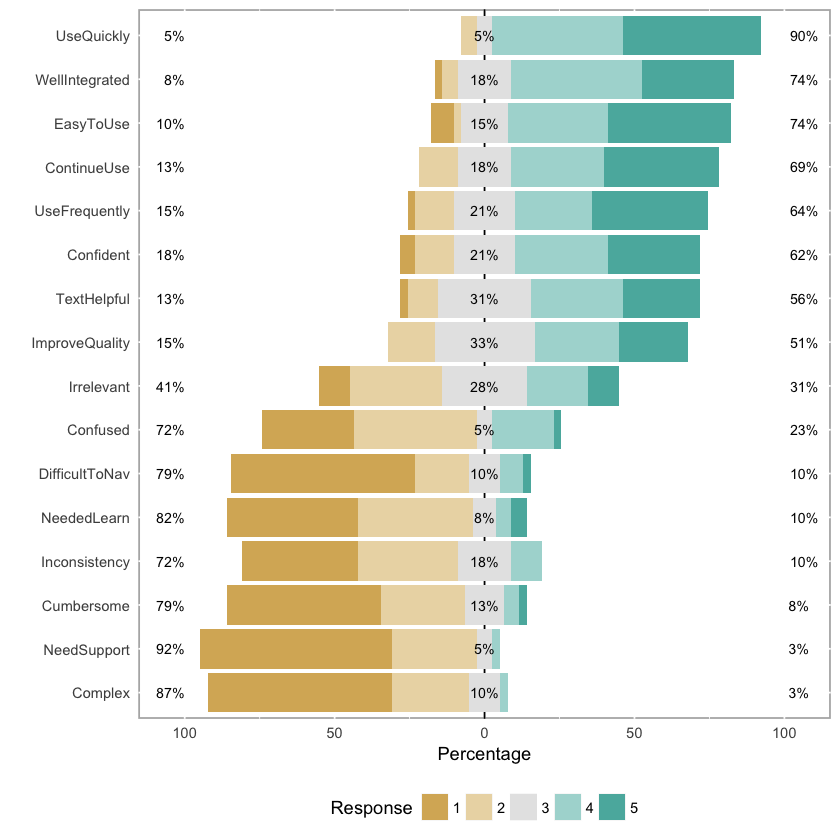

In [91]:
# Legend: 5 = Strongly agree 1 = Stronly disagree
plot(results, type='bar')

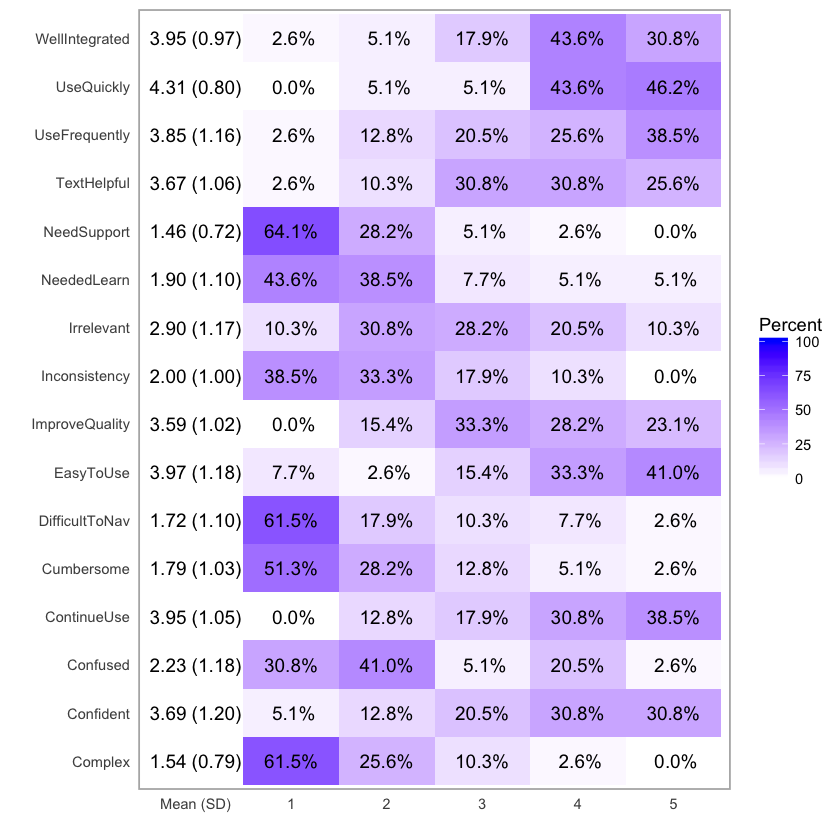

In [92]:
# Alternative hearmap graph
plot(results, 
     type="heat",
           low.color = "white", 
           high.color = "blue",
           text.color = "black", 
           text.size = 4, 
           wrap = 50)

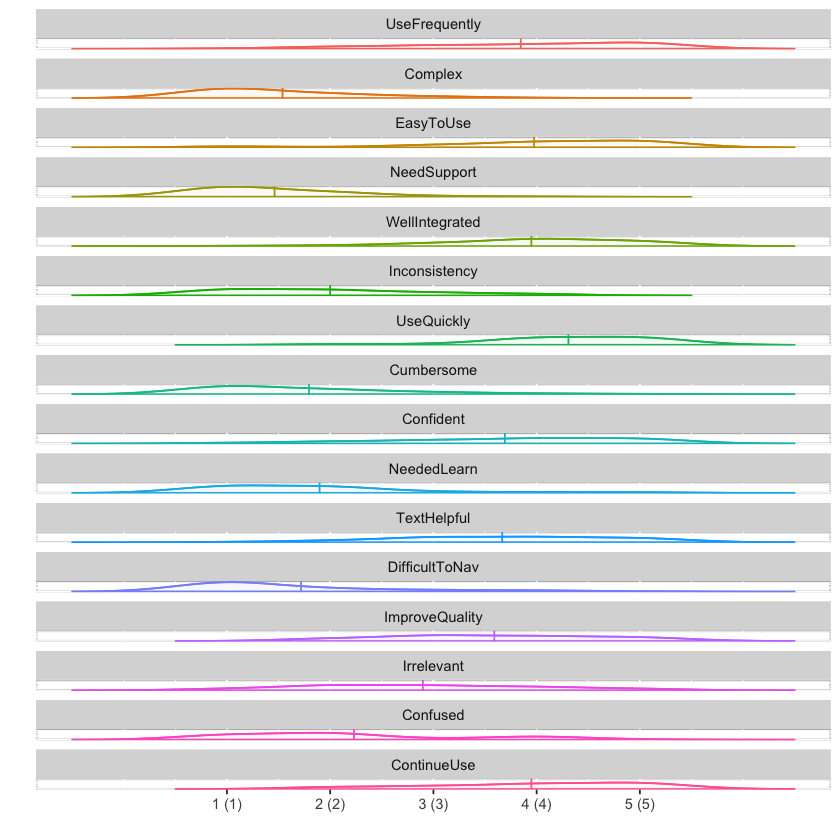

In [93]:
# checkng the distributions
plot(results,
     type="density",
           facet = TRUE, 
           bw = 0.5)

Jason Bryer, J. and Speerschneider, K. Package ‘likert’. cran.r-project.org/web/packages/likert/likert.pdf.

# 6.3 System Usability Score Evaluation

In [88]:
r1 <- c(1, 3:12)
sus <- subset(clean_q2_A, select=r1)
head(sus)

,ParticipantNo,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn
1,1,5,1,4,1,4,2,5,1,5,1
3,2,5,1,4,1,5,1,5,2,5,2
5,3,5,4,5,2,5,2,5,2,2,2
7,4,5,2,5,4,5,2,5,5,4,2
9,5,5,2,5,2,5,1,4,1,4,1
11,6,5,3,3,3,2,4,5,2,1,1


In [89]:
sus

,ParticipantNo,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn
1,1,5,1,4,1,4,2,5,1,5,1
3,2,5,1,4,1,5,1,5,2,5,2
5,3,5,4,5,2,5,2,5,2,2,2
7,4,5,2,5,4,5,2,5,5,4,2
9,5,5,2,5,2,5,1,4,1,4,1
11,6,5,3,3,3,2,4,5,2,1,1
13,7,4,1,5,2,4,3,4,2,4,2
15,8,1,3,4,1,4,1,3,4,2,2
17,9,2,2,2,1,4,3,3,2,3,3
19,10,4,1,4,1,4,1,4,1,4,1


In [90]:
sus_ready <- read.csv("sus_calculation.csv")

In [91]:
head(sus_ready)

Participant,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,SUS.Score
1,5,1,4,1,4,2,5,1,5,1,92.5
2,5,1,4,1,5,1,5,2,5,2,92.5
3,5,4,5,2,5,2,5,2,2,2,75.0
4,5,2,5,4,5,2,5,5,4,2,72.5
5,5,2,5,2,5,1,4,1,4,1,90.0
6,5,3,3,3,2,4,5,2,1,1,57.5


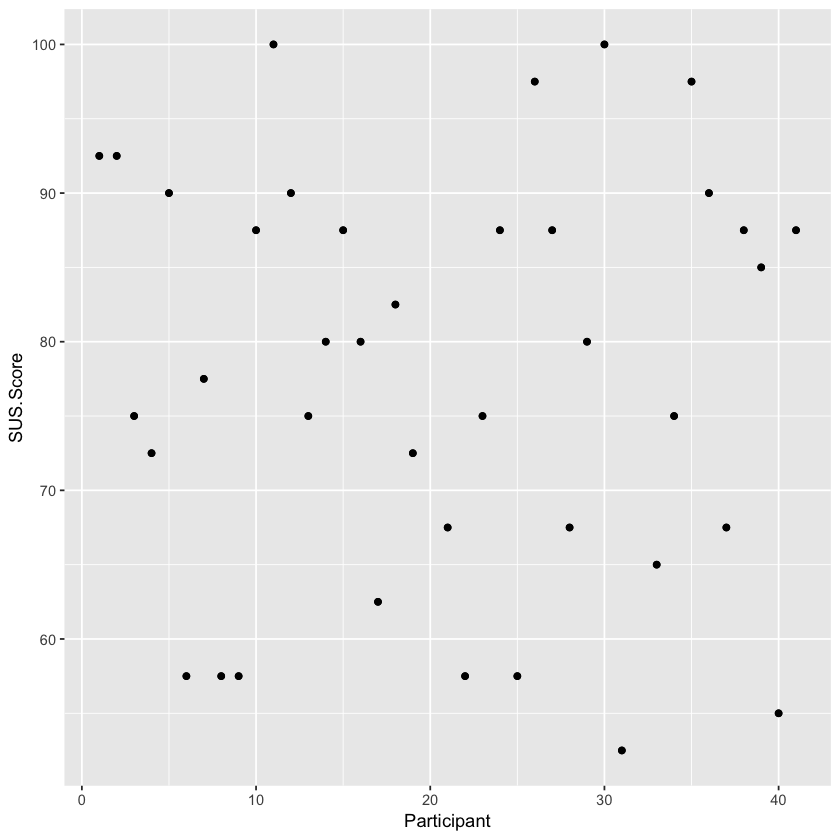

In [92]:
g <- c(2:11)
ggplot(data=sus_ready, aes(x=Participant, y=SUS.Score, group=1)) +
  geom_point()+
  geom_point()

In [93]:
mean(sus_ready$SUS.Score)

[1] 77.69231

The actual SUS calculation is in <b>sus_calculation.xlsx</b><br>
SUS: $60-70=ok$, $70-80=good$, $80+ =excellent$